# test spline fit

## standardize data
## cubic spline
## natural cubic spline
"The use of the term “natural” means that the spline is restricted to be linear beyond the boundary knots. This is enforced by requiring the second derivative to be zero at the boundary. This is frequently desirable to control overfitting around the edges of the data."
## power-law

# experiments
## convergence
1. convergence; run each model and show out of sample predictive performance
1. what other performance measures might we use? (decompose into quartiles and show performance in each)
1. training data drawn from FDC but test data drawn from uniform?

## 2. prior importance

## 3. penalization
1. rather than specifying a few knots, have many knots with penalization
1. could this also work for segmented power law? several segments but have prior at 0 for upper bound

# References
- https://joshua-nugent.github.io/splines/ (good for splines)
- https://bobby.gramacy.com/surrogates/splines.html
- https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-out-of-sample-predictions.html
- https://docs.pymc.io/en/latest/api/generated/pymc.set_data.html

In [ ]:
#covid_obj = COVID_data('US', Population=328.2e6)
#covid_obj.get_dates(data_begin='2/1/20', data_end='9/28/20')
#sir_model = SIR_model_sunode(covid_obj)
#likelihood = {'distribution': 'lognormal', 
#              'sigma': 2}
#prior = {'lam': 1.0, 
#         'mu': 0.5, 
#         'lambda_std': 1.0,
#         'mu_std': 0.2 }
#fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)

In [ ]:
class ObsData():
    pass

class RatingModel(Model):
    def __init__(self, name='', model=None):
        pass
    #def __init__(self, name='', model=None):
    #    super().__init__(name, model)
    
    def setup(self, likelihood, prior):
        pass
    
    def fit(self):
        with model:
            mean_field = pm.fit(method="advi")
        # or pm.fit(method, model=self.model)
    
    def sample(self, n_samples, n_tune):
        with model:
            trace = pm.sample(50000)

class SplineRating(Rating):
    def __init__(self, knots, form='bs'):
        ''' 'bs' for cubic and 'cr' for natural
        Parameters:
          knots : array-like
        '''
        #s_range = #XXX
        #lower_range = np.min(knots)
        #upper_range = np.max(knots)
        #s_range = np.linspace(lower_range, upper_range, 100)
        
        self.B = dmatrix(
            #f"{form}(log_s, knots=knots, degree=3, include_intercept=True) - 1",
            f"{form}(log_s, knots=knots, degree=3, include_intercept=True)", #include intercept, I think
            {"log_s": s_range, "knots": knots[1:-1]},)
        
class SplineRating(Rating):
    def __init__(self, knots, form='bs'):
        ''' 'bs' for cubic and 'cr' for natural
        Parameters:
          knots : array-like
        '''
        #s_range = #XXX
        #lower_range = np.min(knots)
        #upper_range = np.max(knots)
        #s_range = np.linspace(lower_range, upper_range, 100)
        
        self.B = dmatrix(
            #f"{form}(log_s, knots=knots, degree=3, include_intercept=True) - 1",
            f"{form}(log_s, knots=knots, degree=3, include_intercept=True)", #include intercept, I think
            {"log_s": s_range, "knots": knots[1:-1]},)


class PowerLawRating(Rating):
    pass


In [1]:
import pymc3 as pm
from pymc3 import Model

import numpy as np

from patsy import dmatrix
import patsy



class CustomModel(Model):
    # 1) override init
    def __init__(self, mean=0, sd=1, name='', model=None):
        super().__init__(name, model)
        pm.Normal('v2', mu=mean, sigma=sd)
        pm.Normal('v4', mu=mean, sigma=sd)
        
class RatingModel(Model):
    def __init__(self, name='', model=None):
        super().__init__(name, model)
    
    def setup(self, likelihood, prior):
        pass
    
    def fit(self):
        with model:
            mean_field = pm.fit(method="advi")
        # or pm.fit(method, model=self.model)
    
    def sample(self, n_samples, n_tune):
        with model:
            trace = pm.sample(50000)
        
class SplineRatingModel(RatingModel):
    ''' transform y, and compute D untransformed
    '''
    #def __init__(self, log_q, design, knots=5, mean=0, sd=1, name='', model=None):
    def __init__(self, q, dmatrix, knots, mean=0, sd=1, name='', model=None):
        super().__init__(name, model)
        
        # transform q
        self.q_obs = q
        self.q_transform = LogZTransform(q)
        y = self.q_transform.transform(self.q_obs)
        
        self.knots = knots
        self.B = dmatrix
        knot_dims = np.arange(self.B.shape[1])
        
        COORDS = {"obs" : np.arange(len(y)), "splines": np.arange(self.B.shape[1])}
        self.add_coords(COORDS)
        #self.add_coord("splines", values=np.arange(self.B.shape[1]))
        
        #a = pm.Normal("a", 0 , 1)
        w = pm.Normal("w", mu=mean, sd=sd, dims="splines")
        #mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(self.B, order="F"), w.T))
        mu = pm.Deterministic("mu", pm.math.dot(np.asarray(self.B, order="F"), w.T))
        #sigma = pm.Exponential("sigma", 1)
        sigma = pm.HalfCauchy("sigma", 1)
        D = pm.Normal("D", mu, sigma, observed=y, dims="obs")
        
    #def compile
    #def sample
    

class Dmatrix():
    def __init__(self, knots, degree, form):
        self.form = f"{form}(stage, knots=knots, degree={degree}, include_intercept=True) - 1"
        self.knots = knots
    
    def transform(self, stage):
        return patsy.dmatrix(self.form, {"stage": stage, "knots": self.knots[1:-1]})
        
def compute_knots(minimum, maximum, n):
    ''' Return list of knots
    '''
    return np.linspace(minimum, maximum, n)
        


class Transform:
    """ Transformation class

    All children of Transform must have transfom and untransform methods
    """
    pass


class ZTransform(Transform):
    """
    """
    def __init__(self, x):
        self._mean = np.nanmean(x, axis=0)
        self._std = np.nanstd(x, axis=0)
    
    def transform(self, x):
        return (x - self._mean)/self._std

    def untransform(self, x):
        return x*self._std + self._mean

    
class LogZTransform(ZTransform):
    """
    Handle negative values
    """
    def __init__(self, x):

        log_x = np.log(x)
        super().__init__(log_x)

    def transform(self, x):
        log_x = np.log(x)
        return super().transform(log_x)
        

    def untransform(self, z=None):
        #if x is None:
        #    return self._x

        #else:
        log_x = super().untransform(z)
        return np.exp(log_x)

In [2]:
knots = compute_knots(4, 22, 5)
#df['stage']
knots

array([ 4. ,  8.5, 13. , 17.5, 22. ])

In [3]:
import arviz as az

In [4]:
# How to fit a spline
# import rating data
import pandas as pd
import arviz as az
df = pd.read_csv('../data/co_channel.csv')


q_transformer = LogZTransform(df['q'])
y = q_transformer.transform(df['q'])


knots = compute_knots(4, 22, 5)
d_transform = Dmatrix(knots, 3, 'bs')
#dmatrix = d_transform.transform(df['stage'])
dmatrix = d_transform.transform(df['stage'])

q=df['q']

spline_model = SplineRatingModel(q, dmatrix, knots, mean=0, sd=1, name='', model=None)

Finished [100%]: Average Loss = -5.0253
Got error No model on context stack. trying to find log_likelihood in translation.
/home/thodson/.local/miniconda3/envs/uncertainty/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


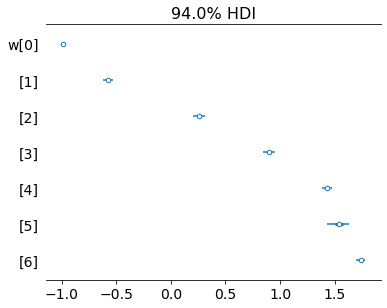

In [5]:
with spline_model:
    mean_field = pm.fit(method="advi", n=100000)
    
az.plot_forest(mean_field.sample(2000), var_names=["w"], combined=False);

In [6]:
hierarchical_loo = az.loo(mean_field.sample(2000), spline_model)

hierarchical_loo.loo

Got error No model on context stack. trying to find log_likelihood in translation.
/home/thodson/.local/miniconda3/envs/uncertainty/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/thodson/.local/miniconda3/envs/uncertainty/lib/python3.7/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 f

22.39262429199782

In [7]:
hierarchical_loo = az.loo(trace, spline_model)

hierarchical_loo.loo

NameError: name 'trace' is not defined

In [ ]:
#pm.model_to_graphviz(spline_model)

In [ ]:
RANDOM_SEED = 8927
with spline_model:
    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace = pm.sample(
        draws=1000,
        tune=1000,
        random_seed=RANDOM_SEED,
        chains=4,
        return_inferencedata=True,
        target_accept=0.9
    )

In [ ]:
az.plot_trace(trace, var_names=["w", "sigma"]);

In [ ]:
az.plot_forest(trace, var_names=["w"], combined=False);

In [ ]:
import pymc3 as pm
#pm.fit?

In [ ]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm

from patsy import dmatrix

In [ ]:
df = pd.read_csv('../data/provo_natural.csv')
df['log_q'] = np.log(df['q'])
df['log_s'] = np.log(df['stage'])

In [ ]:
s_range = np.linspace(df['log_s'].min(), df['log_s'].max(), 100)

In [ ]:
df.plot.scatter("log_s","log_q")

In [ ]:
num_knots = 5
#knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list = np.linspace(df['log_s'].min(),df['log_s'].max(), num_knots)

In [ ]:
# natural spline uses cr

B = dmatrix(
    "bs(log_s, knots=knots, degree=3, include_intercept=True) - 1",
    {"log_s": s_range, "knots": knot_list[1:-1]},
)
B

In [ ]:
# plot spline
spline_df = (
    pd.DataFrame(B)
    .assign(log_s=s_range)
    .melt("log_s", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("log_s", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

In [ ]:
subset

In [ ]:
df['log_s']